# Финальный проект - dating (вариант 3)
******

# Содержание

- [Постановка задачи и описание данных](#task)
- [Загрузка библиотек](#libs)
- [Загрузка данных](#data)
- [Предварительный обзор данных](#preliminary)
    - [Обзор исходных таблиц](#sources)
    - [Создание объектов и функций для удобного доступа к таблицам](#base_fun)
    - [Проверка корректности данных по оплатам](#check_revenue)
    - [Проверка независимости групп](#group_indepencence)
    - [Объединяем данные в большие таблицы](#get_big_tables)
- [Исследование данных](#research)
    - [Построение таблицы с метриками](#main_table)
    - [Сравнение основных метрик](#compare_metrics)
    - [Общая функция для характеризации покупок заданного продукта](#product_purchases_fun)
    - [Смотрим на половое разнообразие](#gender_distr)
    - [Выявление повторных покупок премиум-подписок](#repeat_purchase_prem)
    - [Общие групповые различия расходов](#diff_revenue)
    - [Распределение трат на пробную и обычную подписки в разных группах](#compare_averages)
    - [Сопоставление средних покупок разных продуктов](#products_sales)
    - [Зависимость между полом и покупками](#gender_sales)
    - [Cтрановое разнообразие по расходам и покупателям](#country_sales)
    - [Связь возраста и наличия покупок](#age_sales)
- [Выводы](#summary)

# Постановка задачи и описание данных  <a class="anchor" id="task"></a>

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

**Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*

## Используемые файлы

- `users_test` – информация о пользователях в тестовой группе. 
- `users_control_1` – информация о пользователях в первой контрольной группе. 
- `users_control_2` – информация о пользователях во второй контрольной группе . 
- `transactions_test` – информация о платежах пользователей в тестовой группе. 
- `transactions_control_1` – информация о платежах пользователей в первой контрольной группе. 
- `transactions_control_2` – информация о платежах пользователей во второй контрольной группе 

## Структура файлов

### users_*.csv <a class="anchor" id="assesments"></a>

Информация о пользователях:

- `uid` – идентификатор пользователя
- `age` – возраст
- `attraction_coeff` – коэффициент привлекательности (от 0 до 1000, $ \frac{лайки}{просмотры}*1000 $
- `coins` – число монеток (внутренняя валюта)
- `country` – страна  
- `visit_days` – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- `gender` – пол
- `age_filter_start`  – фильтр поиска, мин. значение 
- `age_filter_end`  – фильтр поиска, макс. значение 
- `views_count` – число полученных оценок 
- `was_premium` – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- `is_premium` –  является ли премиум
- `total_revenue` – нормированная выручка

### transactions_*.csv

Информация о платежах пользователей:

- `uid` – идентификатор пользователя
- `country` – страна
- `joined_at` – дата и время регистрации
- `paid_at` – дата и время покупки
- `revenue` – нормированная выручка
- `payment_id` – идентификатор платежа
- `from_page` – откуда пользователь перешел на страницу оплаты
- `product_type` – тип продукта:
    - `trial_premium` – пробная премиум-подписка,
    - `premium_no_trial` – премиум-подписка без пробной,
    - `coins` – подписка за внутреннюю валюту,
    - `other_type` – другое

## Cтратегия исследования

В ходе эксперимента *"для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы"*. Поскольку итоговым мерилом для бизнеса является прибыль, имеет смысл говорить о (**следствие**) статистически значимом росте полной прибыли для, как минимум, одной из исследуемых (контрольных) групп из-за (**причина**) введения нового способа оплаты подписки. В условии задания про расходы ничего не сказано, расходы на нововведения будем рассматривать как часть текущих расходов на поддержание проекта (зарплаты команды, IT-инфраструктура) и в расчётах учитывать не будем.

Эксперимент проводился для выборок из всего объёма пользователей, поэтому сравнивать необходимо удельные, относительные коэффициенты (метрики). Предварительно, это:

- доля покупателей от всего количества пользователей (конверсия из пользователя в покупателя), $C_1$,
- средние расходы одного пользователя, **RU** (Revenue per User),
- средние расходы одного покупателя, **RB** (Revenue per Buyer),
- количество повторных покупок, **RPR** (Repeat Purchase Rate),
- средний чек, **AP** (Average Price).

Абсолютные метрики:
- доход, **R** (Revenue),
- количество заказов, **O** (Orders),
- количество покупателей, **B** (Buyers),
- количество пользователей, **U** (Users).

Зависимость между ними следующая:
$$ \mathrm{B} = \mathrm{U} \cdot C_1 $$
$$ \mathrm{RB} = \dfrac{\mathrm{R}}{\mathrm{B}}, \mathrm{RU} = \dfrac{\mathrm{R}}{\mathrm{U}} $$
$$ \mathrm{RB} = \mathrm{RU} \cdot C_1 $$
$$ \mathrm{O} = \mathrm{B} \cdot \mathrm{RPR} $$
$$ \mathrm{RB} = \mathrm{AP} \cdot \mathrm{RPR} $$
$$ \mathrm{R} = \mathrm{O} \cdot \mathrm{AP} = (\mathrm{B} \cdot \mathrm{RPR}) \cdot \mathrm{AP} = \mathrm{B} \cdot \mathrm{RB} $$

Так как изменялся параметр, влияющий на возможность покупки обычной, стандартной подписки (а вот у триальной цена не менялась), обязательно надо узнать как различаются по группам:
- среднее количество покупок обычной версии, **RPR_prem**,
- распределение количества покупок обычной версии -- нам нужно понять, есть ли влияние нововведения на вовлечённость пользователей, количество повторных покупок премиума,
- средний доход от продажи премиум-версии на одного покупателя и/или пользователя,
- относительная доля от дохода, которую даёт продажа обычной премиум-версии,
- относительные доли от дохода, которые дают продажи триальной и премиум версий -- нужно понять, простимулировало ли пользователей снижение цены на то, чтобы сразу купить полную подписку.

Необходимо проверить влияние на результаты (значения метрик):
- пола,
- страны,
- возраста.

# Загрузка библиотек <a class="anchor" id="libs"></a>

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import spelling

# Загрузка данных <a class="anchor" id="data"></a>

In [2]:
users_test = pd.read_csv('./users_test.csv', sep = ';')
users_test.name = 'users_test'

users_control_1 = pd.read_csv('./users_control_1.csv', sep = ';')
users_control_1.name = 'users_control_1'

users_control_2 = pd.read_csv('./users_control_2.csv', sep = ';')
users_control_2.name = 'users_control_2'

In [3]:
transactions_test = pd.read_csv('./transactions_test.csv',
                                sep = ';',
                                parse_dates = ['joined_at', 'paid_at'])
transactions_test.name = 'transactions_test'

transactions_control_1 = pd.read_csv('./transactions_control_1.csv',
                                     sep = ';',
                                     parse_dates = ['joined_at', 'paid_at'])
transactions_control_1.name = 'transactions_control_1'

transactions_control_2 = pd.read_csv('./transactions_control_2.csv',
                                     sep = ';',
                                     parse_dates = ['joined_at', 'paid_at'])
transactions_control_2.name = 'transactions_control_2'

# Предварительный обзор данных <a class="anchor" id="preliminary"></a>

## Обзор исходных таблиц <a class="anchor" id="sources"></a>

### users_test

In [4]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


Проверка типов данных:

In [5]:
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

Проверка на дубликаты и отсутствующие значения:

In [6]:
spelling.check_table(users_test)

4308 строк и 13 колонок
36 строк после удаления строк, содержащих NULL
4308 строк после удаления дубликатов


In [7]:
users_test.uid.nunique()

4308

In [8]:
users_test['visit_days'] = users_test['visit_days'].str.split(',')
# .apply(lambda lst: [int(x) for x in lst])

In [9]:
# users_test_no_visits = users_test[users_test['visit_days'].isna()]
# users_test_with_visits = users_test[~users_test['visit_days'].isna()]
# users_test_with_visits['visit_days'] = users_test_with_visits['visit_days'].apply(lambda lst: [int(x) for x in lst])

# users_test = pd.concat([users_test_no_visits, users_test_with_visits]).sort_index()

In [10]:
users_test['visits'] = \
    users_test['visit_days'] \
    .apply(lambda x: len(x) if np.any(pd.notnull(x)) else 0)

In [11]:
users_test['gender'] = users_test['gender'].astype('int').astype('str')

### users_control_1

In [12]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [13]:
users_control_1.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [14]:
spelling.check_table(users_control_1)

4340 строк и 13 колонок
39 строк после удаления строк, содержащих NULL
4340 строк после удаления дубликатов


In [15]:
users_control_1.uid.nunique()

4340

In [16]:
users_control_1['visit_days'] = users_control_1['visit_days'].str.split(',')
users_control_1['visits'] = users_control_1['visit_days'].apply(lambda x: len(x) if np.any(pd.notnull(x)) else 0)

In [17]:
users_control_1['gender'] = users_control_1['gender'].astype('int').astype('str')

### users_control_2

In [18]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [19]:
users_control_2.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [20]:
spelling.check_table(users_control_2)

4264 строки и 13 колонок
37 строк после удаления строк, содержащих NULL
4264 строки после удаления дубликатов


In [21]:
users_control_2.uid.nunique()

4264

In [22]:
users_control_2['visit_days'] = users_control_2['visit_days'].str.split(',')
users_control_2['visits'] = users_control_2['visit_days'].apply(lambda x: len(x) if np.any(pd.notnull(x)) else 0)

In [23]:
users_control_2['gender'] = users_control_2['gender'].astype('int').astype('str')

### transactions_test

In [24]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [25]:
transactions_test.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [26]:
spelling.check_table(transactions_test)

273 строки и 8 колонок
273 строки после удаления строк, содержащих NULL
266 строк после удаления дубликатов


### transactions_control_1

In [27]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [28]:
transactions_control_1.dtypes

uid                    float64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
dtype: object

In [29]:
spelling.check_table(transactions_control_1)

1007 строк и 8 колонок
377 строк после удаления строк, содержащих NULL
357 строк после удаления дубликатов


### transactions_control_2

In [30]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [31]:
transactions_control_2.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [32]:
spelling.check_table(transactions_control_2)

328 строк и 8 колонок
328 строк после удаления строк, содержащих NULL
323 строки после удаления дубликатов


## Создание объектов и функций для удобного доступа к таблицам <a class="anchor" id="base_fun"></a>

In [33]:
tables = {'test': [users_test, transactions_test],
          'control_1': [users_control_1, transactions_control_1],
          'control_2': [users_control_2, transactions_control_2]}

In [34]:
groups = ['test', 'control_1', 'control_2']

In [35]:
def get_users_table(group) :
    return tables[group][0]

def get_transactions_table(group) :
    return tables[group][1]

def update_tables() :
    global tables
    tables = {'test': [users_test, transactions_test],
              'control_1': [users_control_1, transactions_control_1],
              'control_2': [users_control_2, transactions_control_2]}

## Проверка корректности данных по оплатам <a class="anchor" id="check_revenue"></a>

Небольшая проверка на согласование данных между таблицами. В данном случае -- равны ли полные суммы покупок.

In [36]:
for group_name in groups :
    users_table = get_users_table(group_name)
    trans_table = get_transactions_table(group_name)
    
    total_revenue_from_users_table = users_table.total_revenue.sum()
    total_revenue_from_trans_table = trans_table.revenue.sum()
    
    print('Полные траты пользователей в группе "{}" составили:'.format(group_name))
    print(total_revenue_from_users_table, 'согласно таблице пользователей')
    print(total_revenue_from_trans_table, 'согласно таблице транзакций')
    print('Ошибка равна',
          round(100 * \
                    abs(total_revenue_from_trans_table \
                        - total_revenue_from_users_table) \
                    / total_revenue_from_trans_table,\
                1),
          '% или',
          abs(total_revenue_from_trans_table - total_revenue_from_users_table))
    print('----------------------------------------------------')

Полные траты пользователей в группе "test" составили:
2300818 согласно таблице пользователей
2344901 согласно таблице транзакций
Ошибка равна 1.9 % или 44083
----------------------------------------------------
Полные траты пользователей в группе "control_1" составили:
2581267 согласно таблице пользователей
2612311.0 согласно таблице транзакций
Ошибка равна 1.2 % или 31044.0
----------------------------------------------------
Полные траты пользователей в группе "control_2" составили:
1920438 согласно таблице пользователей
1920438 согласно таблице транзакций
Ошибка равна 0.0 % или 0
----------------------------------------------------


В двух первых таблицах есть расхождения, ошибка не превышает 2 %. 

Ответственным за сбор и обработку данных для исследования необходимо будет найти причину такой ошибки и исправить её.

### Смотрим на uid с несовпадающими значениями суммарных трат в группе `test`

In [37]:
def compare_revenue(group_name) :

    revenue_users = \
        get_users_table(group_name) \
        [['uid', 'total_revenue']]

    revenue_trans = \
        get_transactions_table(group_name) \
        .groupby('uid', as_index = False) \
        .agg({'revenue': 'sum'})

    revenue_compare = revenue_users.merge(revenue_trans, on = 'uid', how = 'outer')
    revenue_compare = revenue_compare.fillna(value = {'revenue': 0})
    revenue_compare['revenue'] = revenue_compare['revenue']

    diff = \
        revenue_compare[revenue_compare['revenue'] \
                        != revenue_compare['total_revenue']]

    return diff

In [38]:
diff_test = compare_revenue('test')
diff_test

,uid,total_revenue,revenue
2070,892275462,14885,58968.0


In [39]:
abs(diff_test['total_revenue'] - diff_test['revenue'])

2070    44083.0
dtype: float64

Разница между значениями как раз равна общей разнице между полными суммами покупок в двух таблицах.

Необходимо исключить данного пользователя для чистоты эксперимента.

### Смотрим на uid с несовпадающими значениями суммарных трат в группе `control_1`

In [40]:
diff_control_1 = compare_revenue('control_1')
diff_control_1

,uid,total_revenue,revenue
510,960936960,26,806.0
3370,892355163,0,30264.0


In [41]:
diff_control_1['revenue'] - diff_control_1['total_revenue']

510       780.0
3370    30264.0
dtype: float64

In [42]:
(diff_control_1['revenue'] - diff_control_1['total_revenue']).sum()

31044.0

### Обновляем таблицы

In [43]:
diff_test['uid'].item()

892275462

In [44]:
users_test = users_test[users_test['uid'] != diff_test['uid'].item()]
transactions_test = transactions_test[transactions_test['uid'] != diff_test['uid'].item()]

In [45]:
diff_control_1['uid']

510     960936960
3370    892355163
Name: uid, dtype: int64

In [46]:
users_control_1 = \
    users_control_1[~users_control_1['uid'].isin(diff_control_1['uid'])]

transactions_control_1 = \
    transactions_control_1[~transactions_control_1['uid'].isin(diff_control_1['uid'])]

In [47]:
update_tables()

## Проверка независимости групп  <a class="anchor" id="group_indepencence"></a>

In [48]:
uids_test = users_test['uid']
uids_test.shape[0] == uids_test.nunique()

True

In [49]:
uids_control_1 = users_control_1['uid']
uids_control_1.shape[0] == uids_control_1.nunique()

True

In [50]:
uids_control_2 = users_control_2['uid']
uids_control_2.shape[0] == uids_control_2.nunique()

True

In [51]:
all_uids = [uids_test.to_frame(), uids_control_1.to_frame(), uids_control_2.to_frame()]
N = len(all_uids)

for i in range(N) :
    print(all_uids[i].merge(all_uids[(i + 1) % N], on = 'uid', how = 'inner').shape[0] == 0)

True
True
True


## Объединяем данные в большие таблицы <a class="anchor" id="get_big_tables"></a>

In [52]:
def create_big_table(group_name) :
    big_table = \
        get_transactions_table(group_name) \
        .merge(get_users_table(group_name).drop(['country'], axis = 1),
               on = 'uid',
               how = 'outer')
    
    return big_table

In [53]:
def create_big_tables() :
    big_tables = {}

    for group_name in groups :
        big_tables = big_tables | {group_name : create_big_table(group_name)}
    return big_tables

Создаём объект для хранения больших таблиц с обновлёнными данными:

In [54]:
big_tables = create_big_tables()

In [55]:
def update_big_tables() :
    global big_tables
    big_tables = create_big_tables()

In [56]:
products = ['trial_premium', 'premium_no_trial', 'coins', 'other_type']

# Исследование данных <a class="anchor" id="research"></a>

## Построение таблицы с метриками <a class="anchor" id="main_table"></a>

In [57]:
listof_df = []

# pair = [users_table, transactions_table]
for group_name in groups :
    users_table = get_users_table(group_name)
    transactions_table = get_transactions_table(group_name)
    
    users = users_table['uid'].nunique()
    buyers = users_table.query("total_revenue > 0")["uid"].nunique()
    c1 = round(buyers / users, 4)
    revenue = transactions_table.revenue.sum()
    RB = round(revenue / buyers, 2)
    RU = round(revenue / users, 2)
    orders = transactions_table['payment_id'].count()
    RPR = round(orders / buyers, 4)
    AP = round(RB / RPR, 2)
    
    listof_df.append(pd.DataFrame(index = [group_name],
                                  data = {'users' : users,
                                          'c1' : c1,
                                          'buyers' : buyers,
                                          'RPR' : RPR,
                                          'orders' : orders,
                                          'AP' : AP,
                                          'revenue' : revenue,
                                          'RB' : RB,
                                          'RU' : RU}))

metrics_table = pd.concat(listof_df)
metrics_table

,users,c1,buyers,RPR,orders,AP,revenue,RB,RU
test,4307,0.0337,145,1.8690,271,8435.02,2285933.0,15765.06,530.75
control_1,4338,0.0440,191,1.9529,373,6920.14,2581241.0,13514.35,595.03
control_2,4264,0.0439,187,1.7540,328,5855.03,1920438.0,10269.72,450.38


## Сравнение основных метрик <a class="anchor" id="compare_metrics"></a>

### Различия в C1 между группами

Строим таблицу и графики для сравнения количества (относительного) оплативших в разных группах:

In [58]:
base_c1 = metrics_table.loc['test', 'c1']
metrics_table['c1_change'] = round(metrics_table['c1'] / base_c1, 2)

In [59]:
metrics_table[['c1', 'c1_change']]

,c1,c1_change
test,0.0337,1.00
control_1,0.0440,1.31
control_2,0.0439,1.30


Видно, что доля оплативших в обоих контрольных группах примерно на 30 % больше, чем в тестовой.

## Общая функция для характеризации покупок заданного продукта <a class="anchor" id="product_purchases_fun"></a>

Создаёт таблицу, где для каждого `uid` вычислены:
- количество покупок заданного продукта,
- сумма затрат на покупки.

На вход принимается таблица с информацией о транзакциях -- например,`test` или `transactions_test`.

In [60]:
def product_purchases(group_name, product_type = 'all') :
    """
    @product_type принимает значения из @products = ['trial_premium', 'premium_no_trial', 'coins', 'other_type'].
    Для объединения данных для всех продуктов из списка, нужно вводить значение 'all'.
    """
    table = big_tables[group_name]
    if (product_type != 'all') :
        table = table.query("product_type == @product_type")
    
    df = table \
        .groupby(['uid'], as_index = False) \
        .agg({'paid_at' : 'count', 'revenue' : 'sum'}) \
        .rename(columns = {'paid_at' : 'purchases'}) \
        .sort_values(by = 'purchases', ascending = False) \
        .reset_index(drop = True)
    
    users_table = get_users_table(group_name)
    
    df = df \
        .merge(users_table[['uid', 'gender', 'age', 'attraction_coeff', 'country']],
               on = 'uid',
               how = 'left')
    
    return df

## Смотрим на половое разнообразие <a class="anchor" id="gender_distr"></a>

In [61]:
listof_df = []

for group_name in groups :
    df = product_purchases(group_name, 'all')
    df['group'] = group_name
    df['gender'] = pd.Categorical(df['gender'], ordered = True)
    df['uid'] = df['uid'].astype('int64')
    listof_df.append(df)
    
purchases = pd.concat(listof_df, axis = 0)

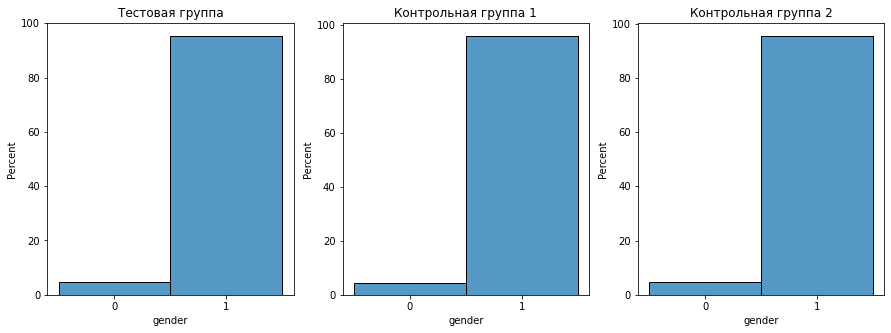

In [62]:
plt.figure(figsize = (15, 5)) # ширина, высота полотна

plt.subplot(1, 3, 1)
plt.title('Тестовая группа', fontsize = 12)
sns.histplot(data = purchases.query("group == 'test'"), x = 'gender', stat = 'percent')

plt.subplot(1, 3, 2)
plt.title('Контрольная группа 1', fontsize = 12)
sns.histplot(data = purchases.query("group == 'control_1'"), x = 'gender', stat = 'percent')

plt.subplot(1, 3, 3)
plt.title('Контрольная группа 2', fontsize = 12)
sns.histplot(data = purchases.query("group == 'control_2'"), x = 'gender', stat = 'percent')

plt.show()

**Вывод:** дисбаланса по полу между группами нет. Очень малое количество пользователей пола '0', по сравнению с противоположным.

## Выявление повторных покупок премиум-подписок <a class="anchor" id="repeat_purchase_prem"></a>

### Пробная подписка (`trial_premium`)

In [63]:
trial_premium_purchases_test = product_purchases('test', 'trial_premium')

trial_premium_purchases_test['purchases'].value_counts()

1    60
2     1
Name: purchases, dtype: int64

In [64]:
trial_premium_purchases_test.head(1)['uid']

0    891297711
Name: uid, dtype: int64

In [65]:
trial_premium_purchases_control_1 = product_purchases('control_1', 'trial_premium')

trial_premium_purchases_control_1['purchases'].value_counts()

1    67
Name: purchases, dtype: int64

In [66]:
trial_premium_purchases_control_2 = product_purchases('control_2', 'trial_premium')

trial_premium_purchases_control_2['purchases'].value_counts()

1    53
Name: purchases, dtype: int64

Лишь в одном случае (для одного пользователя) мы видим повторную покупку пробной подписки, когда человек отменил подписку и потом снова её купил.

### Обычная подписка (`premium_no_trial`)

In [67]:
premium_no_trial_purchases_test = product_purchases('test', 'premium_no_trial')

premium_no_trial_purchases_test['purchases'].value_counts()

1    61
3     3
2     3
Name: purchases, dtype: int64

In [68]:
premium_no_trial_purchases_control_1 = product_purchases('control_1', 'premium_no_trial')

premium_no_trial_purchases_control_1['purchases'].value_counts()

1    92
2     7
Name: purchases, dtype: int64

In [69]:
premium_no_trial_purchases_control_2 = product_purchases('control_2', 'premium_no_trial')

premium_no_trial_purchases_control_2['purchases'].value_counts()

1    98
2     3
3     1
Name: purchases, dtype: int64

**Вывод:** видно абсолютное увеличение количества покупок обычной подписки.

### Выявление покупок разных типов подписок

Для начала попробуем выяснить, есть ли те, кто покупал обе этих подписки.

У нас уже есть список `uid`, которые купили пробную подписку:
```python
trial_premium_purchases_test['uid']
trial_premium_purchases_control_1['uid']
trial_premium_purchases_control_1['uid']
```
и которые купили обычную подписку:
```python
premium_no_trial_purchases_test['uid']
premium_no_trial_purchases_control_1['uid']
premium_no_trial_purchases_control_1['uid']
```

Выявим пересечения.

In [70]:
trial_premium_purchases_test['uid'].to_frame() \
    .merge(premium_no_trial_purchases_test['uid'].to_frame(),
           on = 'uid',
           how = 'inner')

,uid
0,892065108


Здесь лишь одно пересечение, при этом это не тот же `uid = 891297711`, который дважды приобретал пробную подписку.

In [71]:
trial_premium_purchases_control_1['uid'].to_frame() \
    .merge(premium_no_trial_purchases_control_1['uid'].to_frame(),
           on = 'uid',
           how = 'inner')

,uid


In [72]:
trial_premium_purchases_control_2['uid'].to_frame() \
    .merge(premium_no_trial_purchases_control_2['uid'].to_frame(),
           on = 'uid',
           how = 'inner')

,uid


**Вывод:** как для повторных покупок пробной подписки, так и для покупок разных типов подписки, встречается лишь по одному `uid`. В силу малости по сравнению с остальной выборкой, эти случаи можно не рассматривать отдельно.

## Общие групповые различия расходов <a class="anchor" id="diff_revenue"></a>

In [73]:
def divide_with_precaution(num, den) :
    return (num / den) if (den != 0) else 0

In [74]:
def product_sales(product_type, gender = 'all', country = 'all') :
    listof_rows = []

    for group_name in groups :
        big_table = big_tables[group_name]
        users_table = get_users_table(group_name)
        
        # Полное количество людей в группе, купивших данный продукт (БЕЗ фильтрафии по параметрам)
        buyers_all = big_table.query("revenue > 0 & (product_type == @product_type)")['uid'].nunique()
        
        if (gender != 'all') :
            big_table = big_table.query("gender == @gender")
            users_table = users_table.query("gender == @gender")
      
        if (country != 'all') :
            big_table = big_table.query("country == @country")
            users_table = users_table.query("country == @country")

        ## Для входящих в данную группу людей с заданными параметрами:
        users = big_table['uid'].nunique()
        # Количество людей, купившие ДАННЫЙ ПРОДУКТ
        buyers = big_table.query("(revenue > 0) & (product_type == @product_type)")['uid'].nunique()
        # Полная сумма всех покупок ДАННОГО ПРОДУКТА
        revenue = big_table.query("(revenue > 0) & (product_type == @product_type)")['revenue'].sum()
        # Количество людей, совершивших хотя бы одну покупку ЛЮБОГО ПРОДУКТА
        buyers_all_products = users_table.query("total_revenue > 0")['uid'].nunique()
        # Полная сумма всех покупок (по ВСЕМ ПРОДУКТАМ)
        revenue_all_products = users_table.query("total_revenue > 0")['total_revenue'].sum()        
        

        c1 = round(divide_with_precaution(buyers, users), 4)
        # Какая доля покупателей в данной группе имеет такие пол и страну:
        buyers_rel = round(divide_with_precaution(buyers, buyers_all), 2)
        # Какая доля покупателей (с заданными параметрами и из в данной группы) купила именно этот продукт:
        buyers_this_product_rel = round(divide_with_precaution(buyers, buyers_all_products), 2)
        # average revenue per buyer
        RB = round(divide_with_precaution(revenue, buyers), 2)
        # average revenue per user
        RU = round(divide_with_precaution(revenue, users), 2)
        revenue_rel = round(divide_with_precaution(revenue, revenue_all_products), 2)
        
        data = {'users' : users,
                'c1' : c1,
                'buyers' : buyers,
                'buyers_rel' : buyers_rel,
                'buyers_this_product_rel' : buyers_this_product_rel,
                'revenue' : revenue,
                'revenue_rel' : revenue_rel,
                'RB' : RB,
                'RU' : RU}

        table_row = pd.DataFrame(index = [group_name], data = data)
        listof_rows.append(table_row)
        
    summary = pd.concat(listof_rows, axis = 0)
    summary.name = product_type

    return summary

In [75]:
sales_trial_premium = product_sales('trial_premium')
sales_trial_premium

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,4307,0.0142,61,1.0,0.42,800202.0,0.35,13118.07,185.79
control_1,4338,0.0154,67,1.0,0.35,772720.0,0.30,11533.13,178.13
control_2,4264,0.0124,53,1.0,0.28,643981.0,0.34,12150.58,151.03


Для пробной версии премиум подписки:
- уменьшилась доля покупателей (`buyers_this_product_rel`),
- уменьшилась доля прибыли от этих продаж (`revenue_rel`),
- уменьшилась средняя сумма общих расходов от одного пользователя (`RU`).

\* Параметр `buyers_rel` говорит о том, какую долю от всех пользователей составляют пользователи с указанными полом и страной (в данном подразделе мы такого разделения не проводим, поэтому эта величина везде равна 1)

In [76]:
sales_premium_no_trial = product_sales('premium_no_trial')
sales_premium_no_trial

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,4307,0.0156,67,1.0,0.46,810706.0,0.35,12100.09,188.23
control_1,4338,0.0228,99,1.0,0.52,779259.0,0.30,7871.30,179.64
control_2,4264,0.0239,102,1.0,0.55,744809.0,0.39,7302.05,174.67


Для обычной премиум-подписки:
- увеличились доли покупателей (`buyers_this_product_rel`),
- для контрольной группы 1 доля прибыли от продаж этого продукта  (`revenue_rel`)уменьшилась, для контрольной группы 2 - возросла,
- для обоих контрольных групп видно, **как и должно быть по условию задачи**, уменьшение усреднённых расходов (`RU`).

In [77]:
sales_coins = product_sales('coins')
sales_coins

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,4307,0.0121,52,1.0,0.36,566176.0,0.25,10888.00,131.45
control_1,4338,0.0150,65,1.0,0.34,871910.0,0.34,13414.00,200.99
control_2,4264,0.0162,69,1.0,0.37,402909.0,0.21,5839.26,94.49


Для контрольной группы 1 несколько увеличилась доля прибыли (`revenue_rel`) от продажи монет и чуть уменьшилась -- во второй группе.

In [78]:
sales_other_type = product_sales('other_type')
sales_other_type

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,4307,0.0042,18,1.0,0.12,108849.0,0.05,6047.17,25.27
control_1,4338,0.0065,28,1.0,0.15,157352.0,0.06,5619.71,36.27
control_2,4264,0.0077,33,1.0,0.18,128739.0,0.07,3901.18,30.19


Доли прибыли (`revenue_rel`) от продажи прочих продуктов в общей прибыли -- примерно равны для всех групп.

## Распределение трат на пробную и обычную подписки в разных группах <a class="anchor" id="compare_averages"></a>

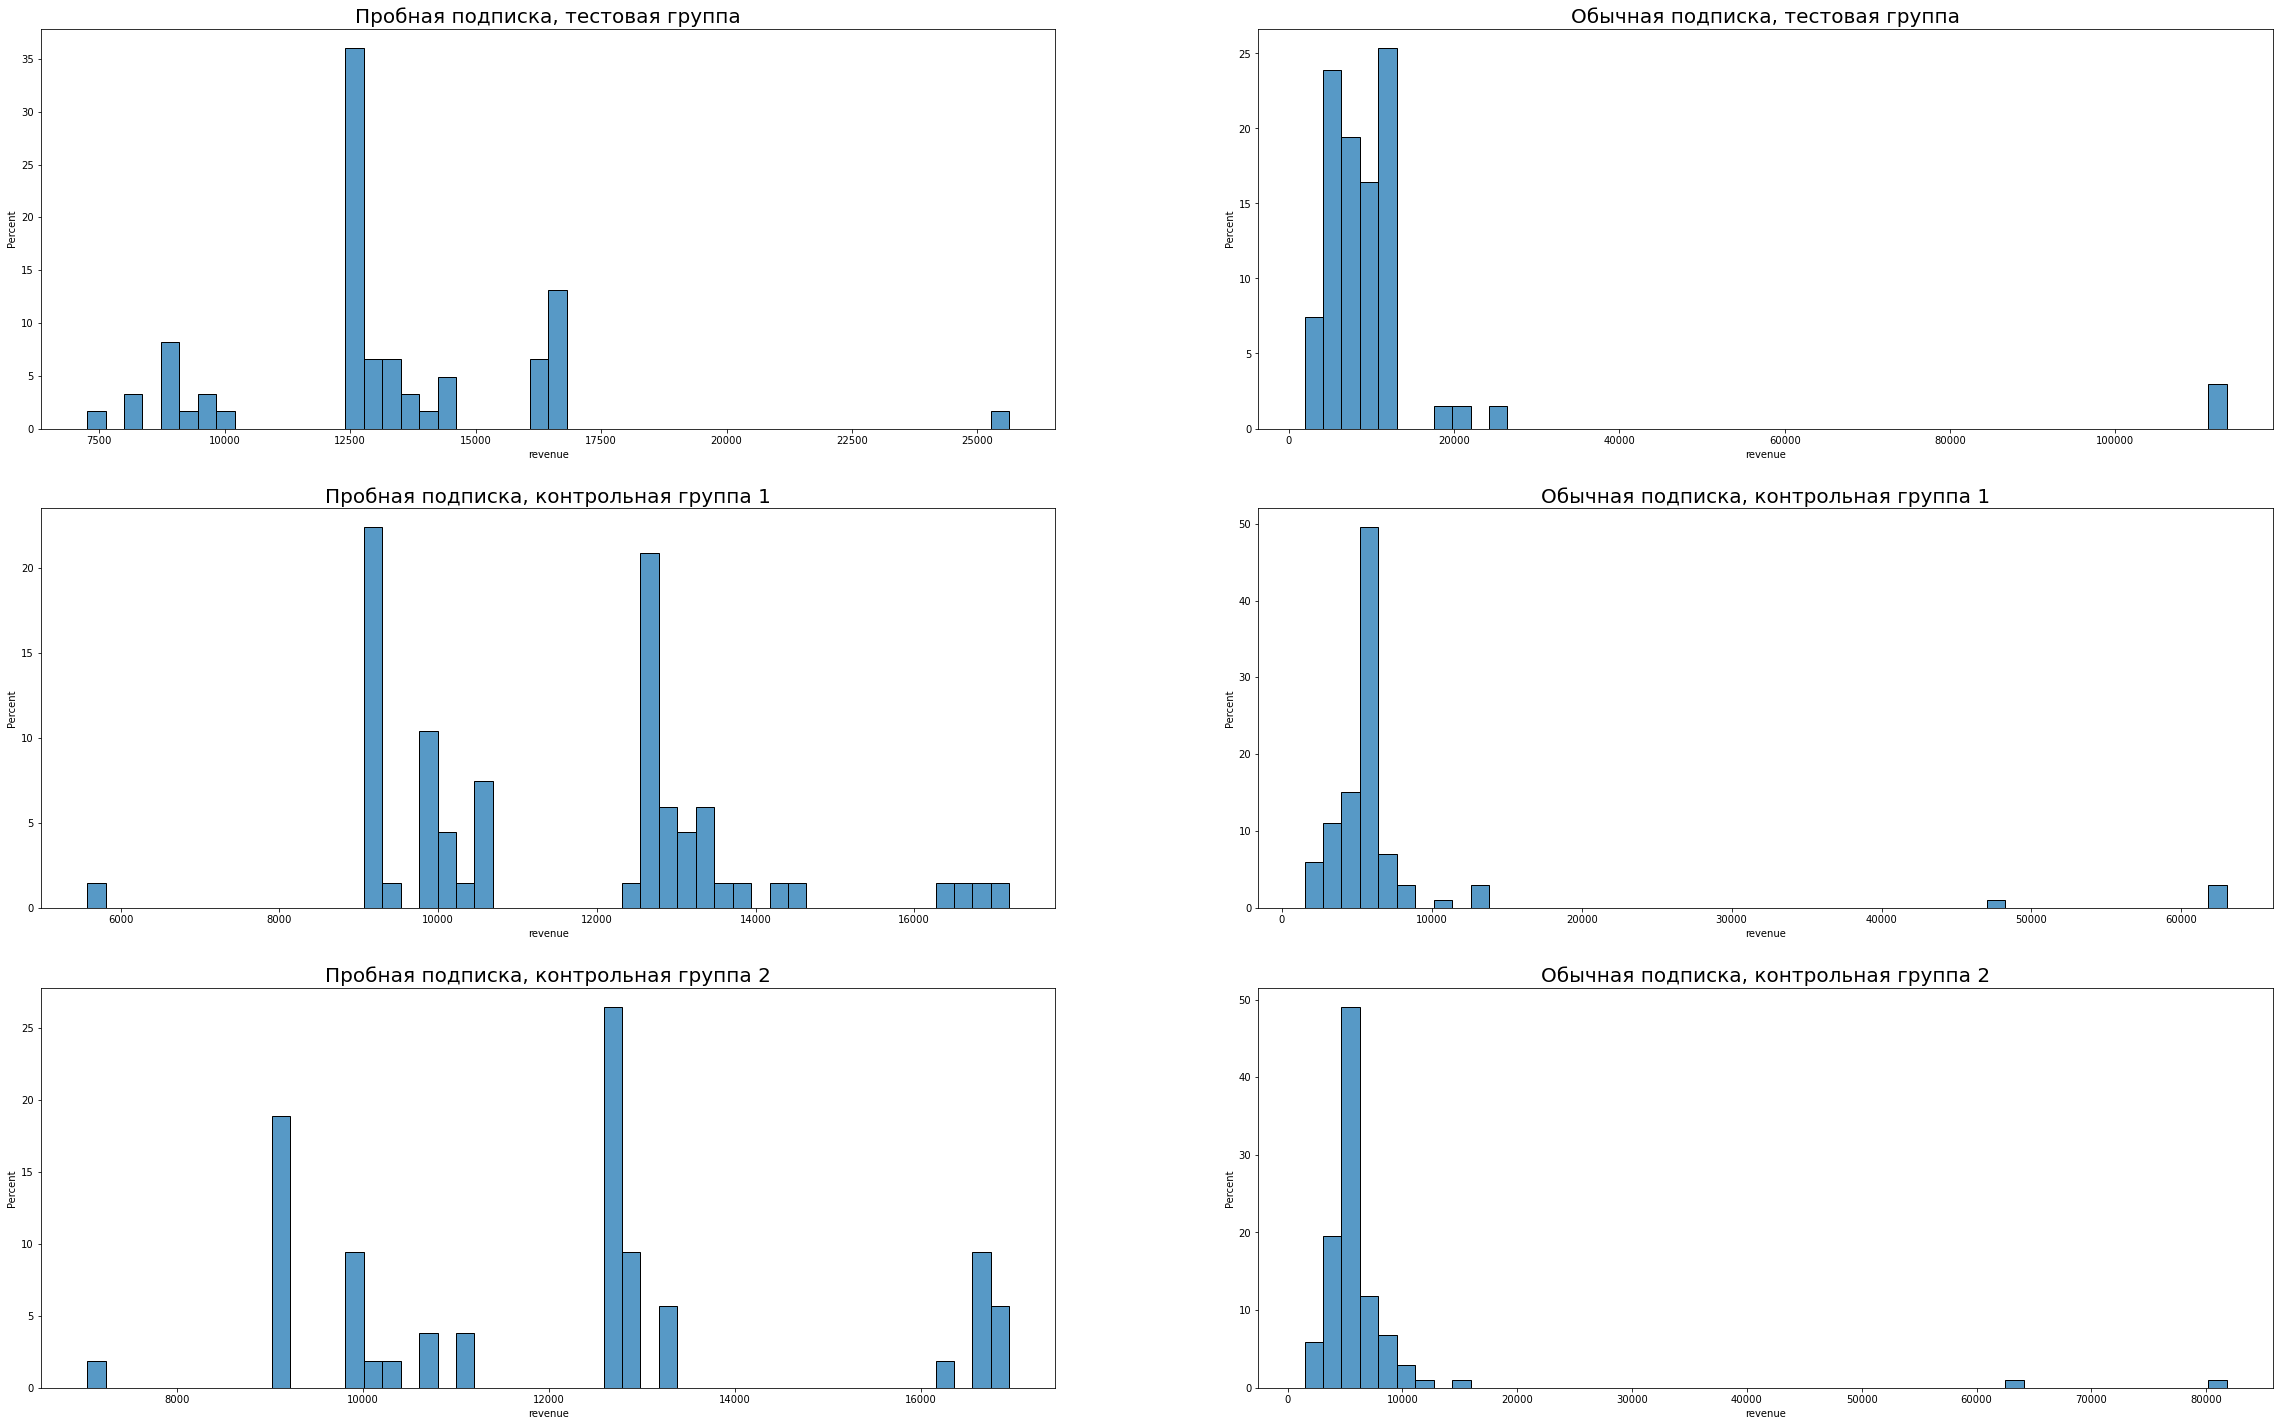

In [79]:
plt.figure(figsize = (40, 25)) # ширина, высота полотна

plt.subplot(3, 2, 1)
sns.histplot(data = trial_premium_purchases_test['revenue'], stat = 'percent', bins = 50)
plt.title('Пробная подписка, тестовая группа', fontsize = 20)

plt.subplot(3, 2, 2)
sns.histplot(data = premium_no_trial_purchases_test['revenue'], stat = 'percent', bins = 50)
plt.title('Обычная подписка, тестовая группа', fontsize = 20)

plt.subplot(3, 2, 3)
sns.histplot(data = trial_premium_purchases_control_1['revenue'], stat = 'percent', bins = 50)
plt.title('Пробная подписка, контрольная группа 1', fontsize = 20)

plt.subplot(3, 2, 4)
sns.histplot(data = premium_no_trial_purchases_control_1['revenue'], stat = 'percent', bins = 50)
plt.title('Обычная подписка, контрольная группа 1', fontsize = 20)

plt.subplot(3, 2, 5)
sns.histplot(data = trial_premium_purchases_control_2['revenue'], stat = 'percent', bins = 50)
plt.title('Пробная подписка, контрольная группа 2', fontsize = 20)

plt.subplot(3, 2, 6)
sns.histplot(data = premium_no_trial_purchases_control_2['revenue'], stat = 'percent', bins = 50)
plt.title('Обычная подписка, контрольная группа 2', fontsize = 20)

plt.show()

Для обычной подписки мы видим компактное распределение. Проведём сравнение средних -- чтобы показать, что удельные траты пользователей в группах в таблице ```product_sales('premium_no_trial')``` действительно различны.

In [80]:
from scipy.stats import mannwhitneyu

In [81]:
mannwhitneyu(premium_no_trial_purchases_test['revenue'],
             premium_no_trial_purchases_control_1['revenue'])

MannwhitneyuResult(statistic=4949.5, pvalue=5.962668862144281e-08)

In [82]:
mannwhitneyu(premium_no_trial_purchases_test['revenue'],
             premium_no_trial_purchases_control_2['revenue'])

MannwhitneyuResult(statistic=5034.5, pvalue=1.5494296303089133e-07)

In [83]:
mannwhitneyu(premium_no_trial_purchases_control_1['revenue'],
             premium_no_trial_purchases_control_2['revenue'])

MannwhitneyuResult(statistic=4848.0, pvalue=0.6169279889276287)

Значения средних расходов покупателей (на приобретение обычной подписки) для обоих контрольных групп значимо отличаются от тестовой группы, но при этом близки друг к другу.

Изменение доли купивших:

In [84]:
product_sales_1 = product_sales('premium_no_trial')

base_buyers_rel_1 = product_sales_1.loc['test', 'buyers_rel']
product_sales_1['buyers_rel_change_pc'] = round(100 * (product_sales_1['buyers_rel'] / base_buyers_rel_1 - 1), 1)

base_RU_1 = product_sales_1.loc['test', 'RU']
product_sales_1['RU_change_pc'] = round(100 * (product_sales_1['RU'] / base_RU_1 - 1), 1)

product_sales_1

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU,buyers_rel_change_pc,RU_change_pc
test,4307,0.0156,67,1.0,0.46,810706.0,0.35,12100.09,188.23,0.0,0.0
control_1,4338,0.0228,99,1.0,0.52,779259.0,0.30,7871.30,179.64,0.0,-4.6
control_2,4264,0.0239,102,1.0,0.55,744809.0,0.39,7302.05,174.67,0.0,-7.2


В первой контрольной группе количество купивших обычную премиум подписку увеличилось более чем на 12 %, во второй - более чем на 18 %.

Однако, мы получили снижение средней величины покупок одного пользователя (дохода с продажи данного продукта, в расчёте на одного пользователя) (**RU**) на 4 % и 8 % соответственно, то есть увеличение количества покупок не компенсирует снижения цены.

**Вывод:** увеличение притока покупателей обычной подписки не компенсирует снижение цены.

## Сопоставление средних покупок разных продуктов <a class="anchor" id="products_sales"></a>

In [85]:
sales_trial_premium.reset_index().rename(columns = {'index': 'group'})

,group,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
0,test,4307,0.0142,61,1.0,0.42,800202.0,0.35,13118.07,185.79
1,control_1,4338,0.0154,67,1.0,0.35,772720.0,0.30,11533.13,178.13
2,control_2,4264,0.0124,53,1.0,0.28,643981.0,0.34,12150.58,151.03


In [86]:
sales = [sales_trial_premium,
         sales_premium_no_trial,
         sales_coins,
         sales_other_type]

In [87]:
tmp_lst = []
for ps in sales :
    tmp_df = ps.reset_index().rename(columns = {'index': 'group'})[['revenue', 'revenue_rel', 'RU', 'group']]
    tmp_df['product'] = ps.name
    tmp_lst.append(tmp_df)

summary = pd.concat(tmp_lst, axis = 0).reset_index(drop = True)

In [88]:
summary

,revenue,revenue_rel,RU,group,product
0,800202.0,0.35,185.79,test,trial_premium
1,772720.0,0.30,178.13,control_1,trial_premium
2,643981.0,0.34,151.03,control_2,trial_premium
3,810706.0,0.35,188.23,test,premium_no_trial
4,779259.0,0.30,179.64,control_1,premium_no_trial
5,744809.0,0.39,174.67,control_2,premium_no_trial
6,566176.0,0.25,131.45,test,coins
7,871910.0,0.34,200.99,control_1,coins
8,402909.0,0.21,94.49,control_2,coins
9,108849.0,0.05,25.27,test,other_type


In [89]:
new_index = summary.shape[0]

for group_name in groups :
    
    subset = summary[summary['group'] == group_name]
    
    revenue_sum = subset['revenue'].sum()
    revenue_rel_sum = subset['revenue_rel'].sum()
    RU_sum = subset['RU'].sum()
        
    new_row = pd.DataFrame(index = [new_index],
                           data = {'revenue' : revenue_sum,
                                   'revenue_rel' : revenue_rel_sum,
                                   'RU' : RU_sum,
                                   'group' : group_name,
                                   'product' : 'all'})
    
    summary = pd.concat([summary, new_row], axis = 0)
    
    new_index += 1

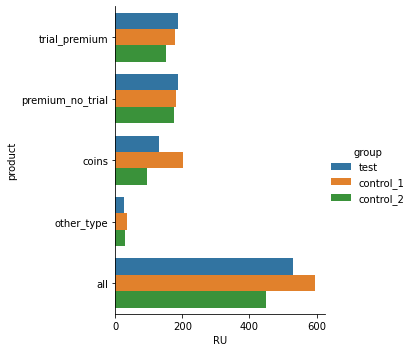

In [90]:
sns.catplot(data = summary,
            kind = 'bar',
            x = 'RU',
            y = 'product',
            hue = 'group',
            ci = None,
            orient = 'h')

**Вывод:** увеличение средней величины всех покупок на одного пользователя дал вариант 1.
Прежде всего, за счёт резкого увеличения продаж монет (`coins`).

## Зависимость между полом и покупками <a class="anchor" id="gender_sales"></a>

In [91]:
listof_df = []

for group_name in groups :
    df = \
        big_tables[group_name] \
        .fillna(value = {'revenue' : 0}) \
        .groupby(['gender', 'product_type']) \
        .agg({'revenue' : 'sum'}) \
        .rename(columns = {'revenue' : group_name })
    
    listof_df.append(df)

pd.concat(listof_df, axis = 1).fillna(0)

test  control_1  control_2
gender product_type                                    
0      other_type             0.0        0.0     2730.0
       premium_no_trial       0.0        0.0    25402.0
       trial_premium      27079.0    45409.0    12727.0
1      coins             566176.0   871910.0   402909.0
       other_type        108849.0   157352.0   126009.0
       premium_no_trial  810706.0   779259.0   719407.0
       trial_premium     773123.0   727311.0   631254.0

Если считать отдельные метрики, то:

In [92]:
product_sales('premium_no_trial', gender = '0')

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,202,0.0000,0,0.00,0.00,0.0,0.00,0.0,0.00
control_1,182,0.0000,0,0.00,0.00,0.0,0.00,0.0,0.00
control_2,195,0.0256,5,0.05,0.71,25402.0,0.62,5080.4,130.27


In [93]:
product_sales('premium_no_trial', gender = '1')

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,4105,0.0163,67,1.00,0.47,810706.0,0.36,12100.09,197.49
control_1,4156,0.0238,99,1.00,0.53,779259.0,0.31,7871.30,187.50
control_2,4069,0.0238,97,0.95,0.54,719407.0,0.38,7416.57,176.80


In [94]:
round(0.0238/0.0163, 1)

1.5

Для пола '1' в обоих случаях в полтора раза увеличилась конверсия в покупателя обычной подписки.

Для пола '0' покупателей в двух группах (в том числе и в тестовой) вообще не было. В контрольной группе 2 конверсия примерно равна конверсии для пола '1'.

In [95]:
product_sales('trial_premium', gender = '0')

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,202,0.0099,2,0.03,1.00,27079.0,1.00,13539.50,134.05
control_1,182,0.0220,4,0.06,1.00,45409.0,1.00,11352.25,249.50
control_2,195,0.0051,1,0.02,0.14,12727.0,0.31,12727.00,65.27


Для пола '0' очень маленькое количество покупателей. Сложно делать статистические выводы.
Пользователи этого пола из тестовой группы покупали только `trial_premium`.

In [96]:
product_sales('trial_premium', gender = '1')

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,4105,0.0144,59,0.97,0.41,773123.0,0.34,13103.78,188.34
control_1,4156,0.0152,63,0.94,0.34,727311.0,0.29,11544.62,175.00
control_2,4069,0.0128,52,0.98,0.29,631254.0,0.34,12139.50,155.14


Конверсия c1 примерно на том же уровне. Доля покупок пробной подписки снизилась, так же как и траты на неё.

In [97]:
product_sales('coins', gender = '0')

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,202,0.0,0,0.0,0.0,0.0,0.0,0,0.0
control_1,182,0.0,0,0.0,0.0,0.0,0.0,0,0.0
control_2,195,0.0,0,0.0,0.0,0.0,0.0,0,0.0


Пол '0' вообще не покупал монеты.

In [98]:
product_sales('coins', gender = '1')

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,4105,0.0127,52,1.0,0.36,566176.0,0.25,10888.00,137.92
control_1,4156,0.0156,65,1.0,0.35,871910.0,0.34,13414.00,209.80
control_2,4069,0.0170,69,1.0,0.38,402909.0,0.21,5839.26,99.02


В обоих случаях рост конверсии, резкое увеличие относительных расходов в контрольной группе 1 и уменьшение - в группе 2.

In [99]:
product_sales('other_type', gender = '0')

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,202,0.0000,0,0.00,0.00,0.0,0.00,0.0,0.0
control_1,182,0.0000,0,0.00,0.00,0.0,0.00,0.0,0.0
control_2,195,0.0051,1,0.03,0.14,2730.0,0.07,2730.0,14.0


Всего один покупатель в группе 2, результат статистически не значимый. В других группах покупателей нет.

In [100]:
product_sales('other_type', gender = '1')

,users,c1,buyers,buyers_rel,buyers_this_product_rel,revenue,revenue_rel,RB,RU
test,4105,0.0044,18,1.00,0.13,108849.0,0.05,6047.17,26.52
control_1,4156,0.0067,28,1.00,0.15,157352.0,0.06,5619.71,37.86
control_2,4069,0.0079,32,0.97,0.18,126009.0,0.07,3937.78,30.97


Виден рост количества покупателей пола '1' и суммы их расходов на "прочие" продукты.

**Выводы:**

1. Нужно значительное привлечение пользователей пола '0'. Дабы исследования давали статистически значимые результаты. В отдельных случаях конверсия в покупателя близка к значениям для пола '1', однако в большинстве случаев она или нулевая, или намного меньше таковой для пола '1'.
2. Возможным вариантом исследования является введение больших скидок на подписку для пола '0'.
3. Пол '1', 'coins': в обоих обоих контрольных группах рост конверсии, с резким увеличие относительных расходов в контрольной группе 1 и уменьшением - в группе 2. Что соответствует общей картине.

## Cтрановое разнообразие по расходам и покупателям <a class="anchor" id="country_sales"></a>

In [101]:
revenue_by_countries = \
    purchases \
    .groupby(['country']) \
    .agg({'revenue' : 'sum', 'uid' : 'nunique'})

# Сразу посчитаем метрику прибыли на одного пользователя
revenue_by_countries['RU'] = round(revenue_by_countries['revenue'] / revenue_by_countries['uid'], 2)

revenue_by_countries = revenue_by_countries.sort_values(by = ['uid'], ascending = False)

In [102]:
countries_with_money = revenue_by_countries.query("revenue > 0")

In [103]:
countries_with_money

,revenue,uid,RU
country,,,
United States of America,2019732.0,4406,458.40
Argentina,453726.0,1182,383.86
France,572156.0,1104,518.26
Italy,866112.0,954,907.87
Spain,578266.0,953,606.78
Chile,276120.0,845,326.77
United Arab Emirates,406471.0,644,631.17
Germany,191503.0,599,319.70
United Kingdom (Great Britain),372814.0,461,808.71


Стран, пользователи которых совершали какие-то покупки:

In [104]:
countries_with_money.shape[0]

22

Тогда как всего стран:

In [105]:
revenue_by_countries.shape[0]

72

**Вывод:** ни в тестовой, ни в контрольных группах никак не проявили себя пользователи из 72 - 22 = 50 стран. Необходимо понять, как можно продать пользователям из этих стран платные услуги.

Также видно, что для отдельных стран (*Литва, Австрия, Латвия*) получены очень большие значения удельной средней величины покупок при очень небольшом числе пользователей -- то есть за счёт отдельных особо богатых пользователей.

В *Турции* число богатых покупателей достаточно большое -- 18 человек.

Остальные страны можно поделить на две категории исходя из медианного значения удельных трат:

In [107]:
RU_median = round(countries_with_money['RU'].median(), 2)
RU_median

618.97

In [108]:
countries_with_money[(countries_with_money['RU'] > 2*RU_median)] \
    .sort_values(by = ['RU'], ascending = False)

,revenue,uid,RU
country,,,
Lithuania,12766.0,1,12766.00
Austria,12168.0,2,6084.00
Turkey,100542.0,18,5585.67
Latvia,10101.0,2,5050.50


In [109]:
countries_with_money[(countries_with_money['RU'] >= RU_median) & (countries_with_money['RU'] <= 2*RU_median)] \
    .sort_values(by = ['RU'], ascending = False)

,revenue,uid,RU
country,,,
Israel,282126.0,293,962.89
Italy,866112.0,954,907.87
United Kingdom (Great Britain),372814.0,461,808.71
India,9620.0,12,801.67
Belgium,218530.0,290,753.55
Switzerland,76921.0,112,686.79
United Arab Emirates,406471.0,644,631.17


In [110]:
countries_with_money[(countries_with_money['RU'] < RU_median)] \
    .sort_values(by = ['RU'], ascending = False)

,revenue,uid,RU
country,,,
Spain,578266.0,953,606.78
France,572156.0,1104,518.26
Canada,186056.0,405,459.40
United States of America,2019732.0,4406,458.40
Mexico,6214.0,15,414.27
Argentina,453726.0,1182,383.86
Australia,53547.0,163,328.51
Chile,276120.0,845,326.77
Germany,191503.0,599,319.70


In [111]:
purchases 

,uid,purchases,revenue,gender,age,attraction_coeff,country,group
0,892236423,14,95823.0,1,23,262,United States of America,test
1,892065108,9,47242.0,1,99,475,France,test
2,892057347,9,30459.0,1,29,366,France,test
3,892339626,9,17758.0,1,37,684,United States of America,test
4,891174411,6,28080.0,1,35,150,Israel,test
...,...,...,...,...,...,...,...,...
4259,891462819,0,0.0,1,21,0,Chile,control_2
4260,891462984,0,0.0,1,16,0,United States of America,control_2
4261,891463065,0,0.0,1,34,903,Argentina,control_2
4262,891463146,0,0.0,1,48,500,France,control_2


In [112]:
listof_df = []

for group_name in groups :
    df = \
        purchases \
        .query("group == @group_name") \
        .groupby('country') \
        .agg({'revenue': 'sum', 'uid' : 'count'}) \
        .rename(columns = {'uid' : 'U', 'revenue' : 'R'}) \
        .sort_values('country')
    
    df['RU'] = round(df['R'] / df['U'], 2)
    
    df2 = \
        purchases \
        .query("(group == @group_name) & (purchases > 0)") \
        .groupby('country') \
        .agg({'uid': 'nunique'}) \
        .rename(columns = {'uid' : 'B'}) \
        .sort_values('country')
    
    df = df.merge(df2, on = 'country', how = 'left').fillna(0)
    
    df = df \
        .rename(columns = {'R': 'R_' + group_name,
                           'U': 'U_' + group_name,
                           'B': 'B_' + group_name,
                           'RU': 'RU_' + group_name})
  

    listof_df.append(df)

countries_summary = pd.concat(listof_df, axis = 1).fillna(0)

In [113]:
countries_summary

,R_test,U_test,RU_test,B_test,R_control_1,U_control_1,RU_control_1,B_control_1,R_control_2,U_control_2,RU_control_2,B_control_2
country,,,,,,,,,,,,
Algeria,0.0,2.0,0.00,0.0,0.0,2.0,0.00,0.0,0.0,0.0,0.00,0.0
Argentina,188019.0,396.0,474.80,7.0,144690.0,389.0,371.95,12.0,121017.0,397.0,304.83,10.0
Australia,12597.0,62.0,203.18,1.0,18304.0,50.0,366.08,3.0,22646.0,51.0,444.04,2.0
Azerbaijan,0.0,1.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
Belgium,62686.0,92.0,681.37,4.0,45630.0,108.0,422.50,4.0,110214.0,90.0,1224.60,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
New Zealand,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.00,0.0
Nicaragua,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.00,0.0
Paraguay,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.00,0.0


Страны, где не было нулевых продаж ни в одной группе (группа стран А (англ.)).

In [114]:
group_countries_A = \
    countries_summary \
    .query("RU_test * RU_control_1 * RU_control_2 > 0")
    
group_countries_A

,R_test,U_test,RU_test,B_test,R_control_1,U_control_1,RU_control_1,B_control_1,R_control_2,U_control_2,RU_control_2,B_control_2
country,,,,,,,,,,,,
Argentina,188019.0,396.0,474.80,7.0,144690.0,389.0,371.95,12.0,121017.0,397.0,304.83,10.0
Australia,12597.0,62.0,203.18,1.0,18304.0,50.0,366.08,3.0,22646.0,51.0,444.04,2.0
Belgium,62686.0,92.0,681.37,4.0,45630.0,108.0,422.50,4.0,110214.0,90.0,1224.60,10.0
Canada,63466.0,137.0,463.26,6.0,92053.0,134.0,686.96,9.0,30537.0,134.0,227.89,4.0
Chile,69940.0,272.0,257.13,4.0,97565.0,287.0,339.95,10.0,108615.0,286.0,379.77,11.0
France,238732.0,358.0,666.85,12.0,184353.0,370.0,498.25,22.0,149071.0,376.0,396.47,19.0
Germany,96096.0,209.0,459.79,7.0,23998.0,188.0,127.65,5.0,71409.0,202.0,353.51,5.0
Israel,94809.0,106.0,894.42,5.0,118391.0,109.0,1086.16,14.0,68926.0,78.0,883.67,6.0
Italy,113425.0,323.0,351.16,9.0,633698.0,338.0,1874.85,17.0,118989.0,293.0,406.11,16.0


Страны, где нулевые продажи были хотя бы в одной группе (группа стран B (англ.)):

In [115]:
group_countries_B = \
    countries_summary[['RU_test', 'U_test', 'B_test',
                       'RU_control_1', 'U_control_1', 'B_control_1',
                       'RU_control_2', 'U_control_2', 'B_control_2']] \
    .query("(RU_test + RU_control_1 + RU_control_2 > 0) & (RU_test * RU_control_1 * RU_control_2 == 0)")

group_countries_B

,RU_test,U_test,B_test,RU_control_1,U_control_1,B_control_1,RU_control_2,U_control_2,B_control_2
country,,,,,,,,,
India,0.00,4.0,0.0,1603.33,6.0,2.0,0.00,2.0,0.0
Latvia,5050.50,2.0,1.0,0.00,0.0,0.0,0.00,0.0,0.0
Mexico,887.71,7.0,1.0,0.00,4.0,0.0,0.00,4.0,0.0
Portugal,0.00,91.0,0.0,194.35,100.0,2.0,538.07,100.0,6.0
Ukraine,0.00,15.0,0.0,0.00,8.0,0.0,493.28,18.0,1.0
Austria,0.00,0.0,0.0,0.00,0.0,0.0,6084.00,2.0,1.0
Lithuania,0.00,0.0,0.0,0.00,0.0,0.0,12766.00,1.0,1.0


Как видим, последние две страны относятся к странам с немногочисленными богатыми клиентами это покупки всего одного человека (и такой рост можно рассматривать как выброс).

В Украине -- рост в контрольной группе 2 не такой большой, но значительный, однако там тоже покупки одного клиента, при полной выборке пользователей всего в 18 человек < 30 и << 100.

В Португалии выборки во всех группах около 100 человек. Включаем её в **группу А**.

В **группу B** включим Турцию, так как там рост продаж обеспечил всего один сверхбогатый покупатель.

В **группе C** -- все остальные страны, где никто не купил ничего.

In [116]:
group_countries_A = pd.concat([group_countries_A,
                               group_countries_B[group_countries_B.index == 'Portugal']],
                              axis = 0)

group_countries_B = pd.concat([group_countries_B,
                               group_countries_A[group_countries_A.index == 'Turkey']],
                              axis = 0)

group_countries_A = group_countries_A[group_countries_A.index != 'Turkey']
group_countries_B = group_countries_B[group_countries_B.index != 'Portugal']

## Связь возраста и наличия покупок

In [117]:
def age_group(age) :
    if (age <= 25) :
        group = 'young'
    elif (age <= 35) :
        group = 'middle'
    elif (age < 50) :
        group = 'mature'
    else :
        group = 'old'
    return group

In [118]:
age_groups = ['young', 'middle', 'mature', 'old']

In [119]:
def buyers(group_name, age) :
    users_table = get_users_table(group_name)
    buyers = users_table.query("(total_revenue > 0) & (age == @age)")['uid'].nunique()
    return buyers

In [120]:
listof_summary_by_age = []

for group_name in groups :
    df = \
        product_purchases(group_name, 'all') \
        .groupby('age', as_index = False) \
        .agg({'uid': 'count', 'purchases': 'sum', 'revenue' : sum}) \
        .rename(columns = {'uid' : 'users'})
    df = df.query("age < 90")
    df['age_group'] = df['age'].apply(age_group)
    df['buyers'] = df['age'].apply(lambda x: buyers(group_name, x))

    df_2 = \
        df \
        .groupby('age_group', as_index = False) \
        .agg({'users': sum, 'buyers': sum, 'purchases': sum, 'revenue' : sum})
    df_2['RU'] = df_2['revenue'] / df_2['users']
    df_2['c1'] = df_2['buyers'] / df_2['users']
    df_2['age_group'] = \
        pd.Categorical(df_2['age_group'],
                       ordered = True,
                       categories = age_groups)
    
    df_2 = df_2.sort_values(by = 'age_group', ascending = True).reset_index(drop = True)
    df_2['group'] = group_name
    
    listof_summary_by_age.append(df_2)

summary_by_age = pd.concat(listof_summary_by_age, axis = 0).reset_index(drop = True)

In [121]:
summary_by_age

,age_group,users,buyers,purchases,revenue,RU,c1,group
0,young,1305,37,74,584311.0,447.747893,0.028352,test
1,middle,1657,57,111,891592.0,538.076041,0.034400,test
2,mature,1092,41,65,676104.0,619.142857,0.037546,test
3,old,245,9,12,86684.0,353.812245,0.036735,test
4,young,1318,62,152,1206608.0,915.484067,0.047041,control_1
5,middle,1600,75,132,771771.0,482.356875,0.046875,control_1
6,mature,1155,42,75,490373.0,424.565368,0.036364,control_1
7,old,256,11,13,105157.0,410.769531,0.042969,control_1
8,young,1298,55,87,426296.0,328.425270,0.042373,control_2
9,middle,1627,73,131,848523.0,521.526122,0.044868,control_2


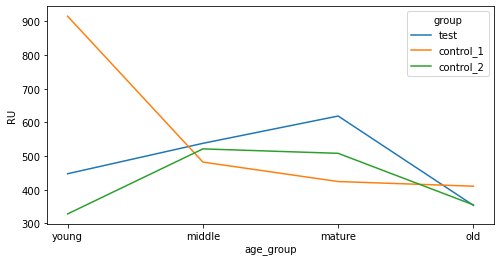

In [122]:
plt.figure(figsize = (8, 4))
sns.lineplot(data = summary_by_age, x = 'age_group', y = 'RU', hue = 'group')
plt.show()

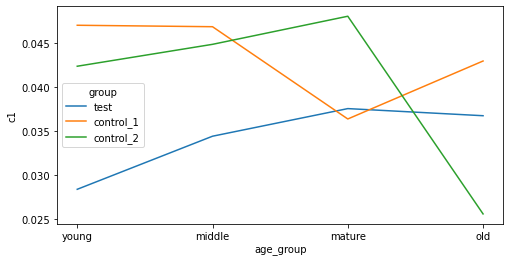

In [123]:
plt.figure(figsize = (8, 4))
sns.lineplot(data = summary_by_age, x = 'age_group', y = 'c1', hue = 'group')
plt.show()

**Вывод:**

Обозначения:
- ТГ - тестовая группа (`test`)
- КГ - контрольная группа (группы)
- КГ_1 - контрольная группа 1 (`control_1`)
- КГ_2 - контрольная группа 1 (`control_2`)

- Конверсия в покупателя:
    1. У молодой (до 25 лет) и взрослой (до 40 лет) аудиторий в обоих КГ выше, чем в тестовой, 
    2. У возрастной (до 50 лет) аудитории падает для КГ_1 и остаётся высокой в КГ_2.
    3. У пожилой (старше 50 лет) аудитории возрастает в КГ_1 и резко падает в КГ_2.
- Средняя величина покупок пользователя:
    1. У молодёжи (до 25 лет) очень высока в КГ_1, падает в КГ_2.
    2. Для более старших возрастов находится ниже или сравнима с тестовой группой.

# Выводы  <a class="anchor" id="summary"></a>

### Общий результат

Доля оплативших (конверсия из пользователя в покупателя) в обоих КГ примерно на 30 % больше, чем в ТГ.

Для пробной версии премиум подписки:
- уменьшилась доля покупателей (`buyers_this_product_rel`),
- уменьшилась доля прибыли от этих продаж (`revenue_rel`),
- уменьшилась средняя сумма общих расходов от одного пользователя (`RU`).

Для обычной премиум-подписки:
- увеличились доли покупателей (`buyers_this_product_rel`),
- для контрольной группы 1 доля прибыли от продаж этого продукта  (`revenue_rel`)уменьшилась, для контрольной группы 2 - возросла,
- для обоих контрольных групп видно, уменьшение усреднённых расходов (`RU`).

В КГ_1 количество купивших обычную премиум-подписку увеличилось более чем на 12 %, в КГ_2 -- более чем на 18 %. Для обычной подписки средняя величина покупок на одного пользователя обоих КГ снижается на 4 % и 8 % соответственно, то есть увеличение количества покупок этой подписки не компенсирует снижения ей цены.

Однако, **если рассматривать общие продажи всех продуктов, увеличение средней величины покупок на одного пользователя есть в КГ_1 -- за счёт резкого увеличения продаж монет (coins)**.

### Влияние пола

Очень малое количество пользователей пола '0', по сравнению с противоположным. Решающее влияние на общую картину оказывает поведение пользователей пола '1'. *Нужно значительное привлечение пользователей этого пола. В том числе для того, чтобы исследования давали статистически значимые результаты.*

В отдельных случаях конверсия в покупателя близка к значениям для пола '1', однако в большинстве случаев она или нулевая, или намного меньше таковой для пола '1'.

Возможным вариантом исследования является *введение больших скидок на подписку для пола '0'.*

### Влияние страны

Ни в ТГ, ни в обоих КГ никак не проявили себя пользователи из 72 - 22 = 50 стран. Необходимо понять, как можно продать пользователям из этих стран платные услуги.

Страны можно разделить на несколько групп (для обозначения используются символы английского алфавита A, B, C):
1. Группа стран A - большое количество пользователей и покупателей, не было нулевых продаж в рамках экспериментальных (ТГ и КГ) групп. Группу можно разделить пополам: в A1 средняя величина покупок на пользователя превышает медианное значение (619 УЕ), в A2 - меньше него.
2. Группа стран B - нулевые продажи как минимум в одной из экспериментальных групп. Например, в Турции лишь в одной группе был всего один очень щедрый покупатель.
3. Группа стран C - не было продаж.

### Влияние возраста

- Конверсия в покупателя:
	1. *У молодой (до 25 лет) и взрослой (до 40 лет) аудиторий в обоих КГ выше, чем в тестовой*.
	2. У возрастной (до 50 лет) аудитории падает для КГ_1 и остаётся высокой в КГ_2.
	3. У пожилой (старше 50 лет) аудитории возрастает в КГ_1 и резко падает в КГ_2.
- Средняя величина покупок пользователя:
	1. *У молодёжи (до 25 лет) очень высока в КГ_1*, падает в КГ_2.
	2. Для более старших возрастов находится ниже или сравнима с тестовой группой.

## Предложения

1. Эксперимент оказался удачным благодаря увеличению продаж монет (`coins`) в КГ_1
2. Нужно искать способы повысить количество пользователей и конвверсию в странах групп B и C.
3. Нужно активно привлекать пользователей пола '0', которых сейчас в несколько раз меньше, чем пользователей противоположного пола.
4. Необходимо искать способы повысить конверсию и покупательную способность взрослой аудитории.